# Monte Carlo Visualizations

Comparison of MLMC vs Unbiased MC methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mlmc_functions import run_mlmc, mu_S, sigma_S
from unbiased_mc_functions import mu_X, run_unbiased_mc, run_unbiased_asian_mc, compute_gamma

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Setup parameters
T = 1.0
K = 1.0
M_param = 4.0
sigma_matrix = 0.5 * np.identity(1)
mu_max = 5
gamma = compute_gamma(sigma_matrix, mu_max, 1, T)
beta = 0.15

## MLMC European Option - Different Epsilon Values

In [2]:
# Run MLMC with different epsilon to see convergence
import time

epsilon_list = [0.003, 0.001,0.0003,0.0001]
mlmc_results = []

for eps in epsilon_list:
    start_time = time.time()
    result = run_mlmc(
        mu_func=mu_S,
        sigma_func=sigma_S,
        T=1.0,
        K=1.0,
        M_param=4.0,
        epsilon=eps,
        max_levels=10,
        N_initial=10000,
        verbose=True
    )
    elapsed_time = time.time() - start_time
    result['time'] = elapsed_time
    mlmc_results.append(result)
    print(f"Epsilon {eps}: Estimate = {result['estimate']:.6f}, Levels = {result['levels']}, Time = {elapsed_time:.2f}s")

MULTILEVEL MONTE CARLO - EUROPEAN OPTION

LEVEL L = 0
Step 2: Initial sampling (N=10000, M=1)
  E[P_0] = 0.194588, Var[P_0] = 0.082454

Step 3: Optimal sample allocation
  Level 0: N_opt = 18,324 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +8,324 samples

LEVEL L = 1
Step 2: Initial sampling (N=10000, M_c=1, M_f=4)
  E[P_1 - P_0] = 0.009983, Var = 0.017005

Step 3: Optimal sample allocation
  Level 0: N_opt = 34,966 (current = 18,324)
  Level 1: N_opt = 7,940 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +16,642 samples

LEVEL L = 2
Step 2: Initial sampling (N=10000, M_c=4, M_f=16)
  E[P_2 - P_1] = -0.002265, Var = 0.005130

Step 3: Optimal sample allocation
  Level 0: N_opt = 53,247 (current = 34,966)
  Level 1: N_opt = 12,091 (current = 10,000)
  Level 2: N_opt = 3,321 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +18,281 samples
  Level 1: +2,091 samples

Step 5: Convergence test (Equation 10)
  Max(|Y_1|/M, |Y_2|) = 2.524347e-03
  Thresho

## Unbiased MC European Option - Different Sample Sizes

In [3]:
# Test Unbiased MC with different sample sizes
N_list = [50000, 100000, 500000, 1000000, 5000000, 10000000, 20000000]
unbiased_results = []

for N in N_list:
    np.random.seed(42)
    
    start_time = time.time()
    # Run unbiased MC
    X_T, X_T_NT, N_T, weights = run_unbiased_mc(
        N_mc=N,
        X_0=0.0,
        beta=beta,
        mu_func=mu_X,
        sigma_0=0.5,
        M=M_param,
        T=T
    )
    
    # Compute European call payoff
    g_X_T = np.maximum(np.exp(X_T) - K, 0)
    g_X_T_NT = np.maximum(np.exp(X_T_NT) - K, 0)
    indicator = (N_T > 0).astype(float)
    payoff = weights * (g_X_T - g_X_T_NT * indicator)
    
    estimate = np.mean(payoff)
    std_error = np.std(payoff) / np.sqrt(len(payoff))
    elapsed_time = time.time() - start_time
    
    unbiased_results.append({'estimate': estimate, 'std_error': std_error, 'time': elapsed_time})
    print(f"N={N}: Est={estimate:.6f} ± {std_error:.6f}, Time={elapsed_time:.2f}s")

N=50000: Est=0.205005 ± 0.001998, Time=0.05s
N=100000: Est=0.205574 ± 0.001548, Time=0.08s


c:\Users\jacqu\MonteCarlo\unbiased_mc_functions.py:159: RuntimeWarning: invalid value encountered in divide
  w = (mu_k - mu_prev) * dW_matrix[:, k] / (sigma_0 * dt_matrix[:, k])


N=500000: Est=0.205268 ± 0.000640, Time=0.50s
N=1000000: Est=0.206018 ± 0.000454, Time=1.07s
N=5000000: Est=0.205672 ± 0.000202, Time=8.92s
N=10000000: Est=0.205613 ± 0.000143, Time=17.27s
N=20000000: Est=0.205633 ± 0.000101, Time=47.32s


## Plot Results

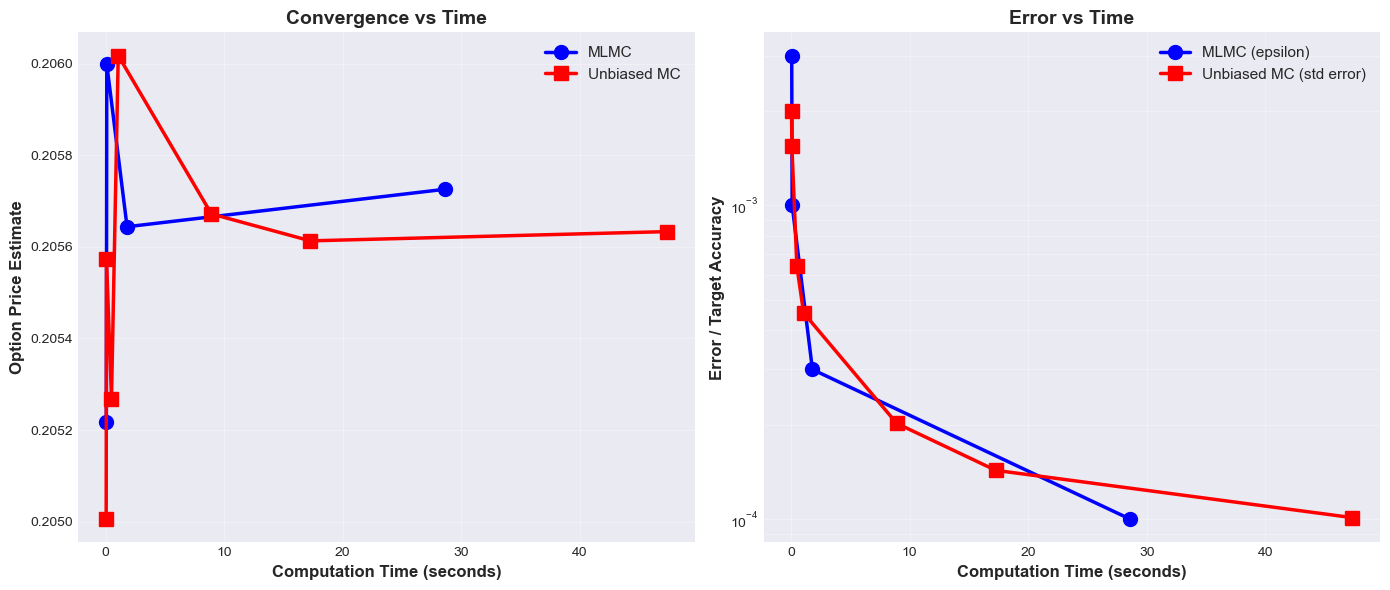

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Estimate vs Time
mlmc_times = [r['time'] for r in mlmc_results]
mlmc_ests = [r['estimate'] for r in mlmc_results]
unb_times = [r['time'] for r in unbiased_results]
unb_ests = [r['estimate'] for r in unbiased_results]

ax1.plot(mlmc_times, mlmc_ests, 'o-', linewidth=2.5, markersize=10, label='MLMC', color='blue')
ax1.plot(unb_times, unb_ests, 's-', linewidth=2.5, markersize=10, label='Unbiased MC', color='red')
ax1.set_xlabel('Computation Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Option Price Estimate', fontsize=12, fontweight='bold')
ax1.set_title('Convergence vs Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Plot 2: Error vs Time (epsilon for MLMC, std_error for Unbiased MC)
mlmc_epsilons = epsilon_list  # Target accuracy (epsilon)
unb_errs = [r['std_error'] for r in unbiased_results]

ax2.semilogy(mlmc_times, mlmc_epsilons, 'o-', linewidth=2.5, markersize=10, label='MLMC (epsilon)', color='blue')
ax2.semilogy(unb_times, unb_errs, 's-', linewidth=2.5, markersize=10, label='Unbiased MC (std error)', color='red')
ax2.set_xlabel('Computation Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Error / Target Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Error vs Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

## Summary

In [5]:
print("\n" + "="*80)
print("MLMC RESULTS")
print("="*80)
print(f"{'Epsilon':<12} {'Estimate':<12} {'Levels':<10} {'Samples':<15} {'Time (s)':<10}")
print("-"*80)
for i, eps in enumerate(epsilon_list):
    r = mlmc_results[i]
    print(f"{eps:<12.4f} {r['estimate']:<12.6f} {r['levels']:<10} {r['total_samples']:<15,} {r['time']:<10.2f}")

print("\n" + "="*80)
print("UNBIASED MC RESULTS")
print("="*80)
print(f"{'N Samples':<15} {'Estimate':<15} {'Std Error':<12} {'Time (s)':<10}")
print("-"*80)
for i, N in enumerate(N_list):
    r = unbiased_results[i]
    print(f"{N:<15,} {r['estimate']:<15.6f} {r['std_error']:<12.6f} {r['time']:<10.2f}")

print("="*80)


MLMC RESULTS
Epsilon      Estimate     Levels     Samples         Time (s)  
--------------------------------------------------------------------------------
0.0030       0.205219     3          75,338          0.06      
0.0010       0.205999     4          842,957         0.10      
0.0003       0.205644     4          9,508,304       1.81      
0.0001       0.205726     5          112,227,574     28.64     

UNBIASED MC RESULTS
N Samples       Estimate        Std Error    Time (s)  
--------------------------------------------------------------------------------
50,000          0.205005        0.001998     0.05      
100,000         0.205574        0.001548     0.08      
500,000         0.205268        0.000640     0.50      
1,000,000       0.206018        0.000454     1.07      
5,000,000       0.205672        0.000202     8.92      
10,000,000      0.205613        0.000143     17.27     
20,000,000      0.205633        0.000101     47.32     


## Asian Option - MLMC

In [6]:
# Run MLMC for Asian option with different epsilon
epsilon_list_asian = [0.003, 0.001,0.0003,0.0001]
mlmc_asian_results = []

for eps in epsilon_list_asian:
    start_time = time.time()
    result = run_mlmc(
        mu_func=mu_S,
        sigma_func=sigma_S,
        T=1.0,
        K=1.0,
        M_param=4.0,
        epsilon=eps,
        max_levels=8,
        N_initial=10000,
        n_asian=10,  # Asian option with 10 timesteps
        M_base=10,
        verbose=True
    )
    elapsed_time = time.time() - start_time
    result['time'] = elapsed_time
    mlmc_asian_results.append(result)
    print(f"Epsilon {eps}: Estimate = {result['estimate']:.6f}, Levels = {result['levels']}, Time = {elapsed_time:.2f}s")

MULTILEVEL MONTE CARLO - ASIAN OPTION (n_asian=10)

LEVEL L = 0
Step 2: Initial sampling (N=10000, M=10)
  E[P_0] = 0.127109, Var[P_0] = 0.051272

Step 3: Optimal sample allocation
  Level 0: N_opt = 11,394 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +1,394 samples

LEVEL L = 1
Step 2: Initial sampling (N=10000, M_c=10, M_f=40)
  E[P_1 - P_0] = -0.000866, Var = 0.000651

Step 3: Optimal sample allocation
  Level 0: N_opt = 13,962 (current = 11,394)
  Level 1: N_opt = 787 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +2,568 samples

LEVEL L = 2
Step 2: Initial sampling (N=10000, M_c=40, M_f=160)
  E[P_2 - P_1] = -0.000087, Var = 0.000186

Step 3: Optimal sample allocation
  Level 0: N_opt = 16,707 (current = 13,962)
  Level 1: N_opt = 942 (current = 10,000)
  Level 2: N_opt = 252 (current = 10,000)

Step 4: Adding extra samples
  Level 0: +2,745 samples

Step 5: Convergence test (Equation 10)
  Max(|Y_1|/M, |Y_2|) = 2.164294e-04
  Threshold = 6.363961e-03
 

## Asian Option - Unbiased MC

In [7]:
# Test Unbiased MC for Asian option with different sample sizes
N_list_asian = [50000, 100000, 500000, 1000000, 5000000]
unbiased_asian_results = []

for N in N_list_asian:
    np.random.seed(42)
    
    start_time = time.time()
    # Run unbiased MC for Asian option
    X_paths, X_zero_paths, psi_estimate = run_unbiased_asian_mc(
        N_mc=N,
        X_0=0.0,
        beta=beta,
        mu_func=mu_X,
        sigma_0=0.5,
        M=M_param,
        n_timesteps=10,
        T=T
    )
    
    estimate = np.mean(psi_estimate)
    std_error = np.std(psi_estimate) / np.sqrt(len(psi_estimate))
    elapsed_time = time.time() - start_time
    
    unbiased_asian_results.append({'estimate': estimate, 'std_error': std_error, 'time': elapsed_time})
    print(f"N={N}: Est={estimate:.6f} ± {std_error:.6f}, Time={elapsed_time:.2f}s")

c:\Users\jacqu\MonteCarlo\unbiased_mc_functions.py:245: RuntimeWarning: invalid value encountered in divide
  w = (mu_j - mu_prev) * dW_mat[:, j] / (sigma_0 * dt_mat[:, j])


N=50000: Est=0.127406 ± 0.001222, Time=0.68s
N=100000: Est=0.127207 ± 0.001073, Time=1.17s
N=500000: Est=0.126852 ± 0.000420, Time=6.97s
N=1000000: Est=0.126867 ± 0.000310, Time=10.68s
N=5000000: Est=0.126595 ± 0.000129, Time=63.18s


## Asian Option - Plots

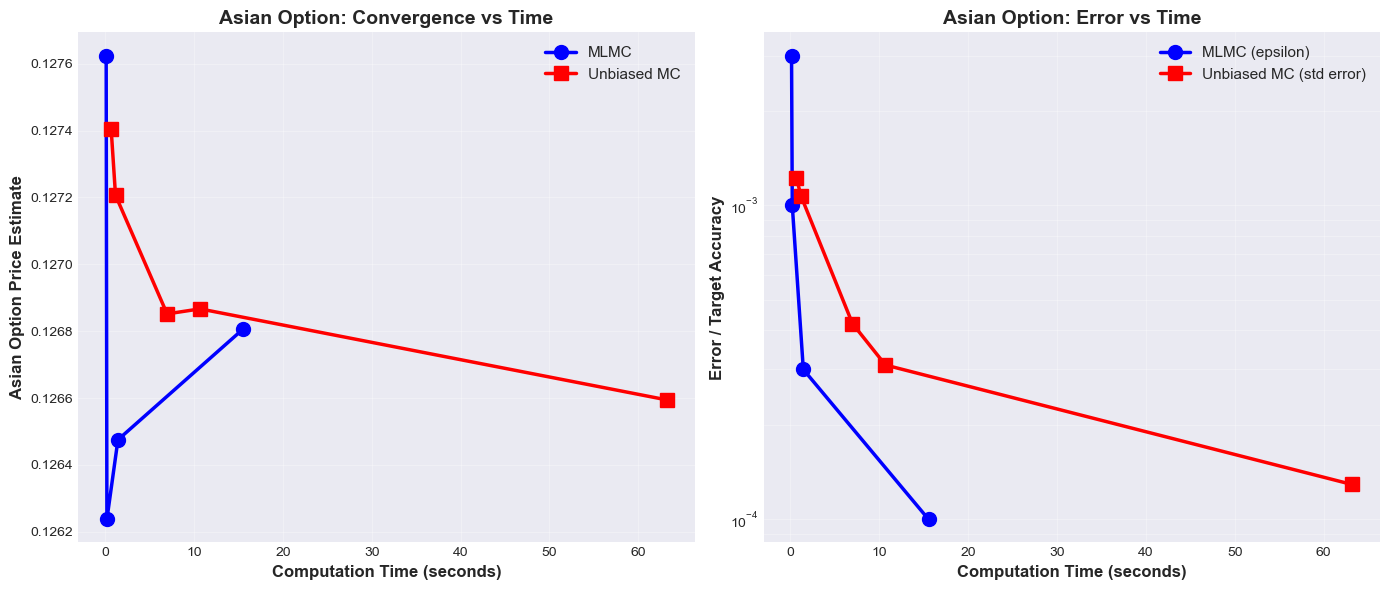

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Estimate vs Time for Asian option
mlmc_asian_times = [r['time'] for r in mlmc_asian_results]
mlmc_asian_ests = [r['estimate'] for r in mlmc_asian_results]
unb_asian_times = [r['time'] for r in unbiased_asian_results]
unb_asian_ests = [r['estimate'] for r in unbiased_asian_results]

ax1.plot(mlmc_asian_times, mlmc_asian_ests, 'o-', linewidth=2.5, markersize=10, label='MLMC', color='blue')
ax1.plot(unb_asian_times, unb_asian_ests, 's-', linewidth=2.5, markersize=10, label='Unbiased MC', color='red')
ax1.set_xlabel('Computation Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Asian Option Price Estimate', fontsize=12, fontweight='bold')
ax1.set_title('Asian Option: Convergence vs Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Plot 2: Error vs Time for Asian option
mlmc_asian_epsilons = epsilon_list_asian
unb_asian_errs = [r['std_error'] for r in unbiased_asian_results]

ax2.semilogy(mlmc_asian_times, mlmc_asian_epsilons, 'o-', linewidth=2.5, markersize=10, label='MLMC (epsilon)', color='blue')
ax2.semilogy(unb_asian_times, unb_asian_errs, 's-', linewidth=2.5, markersize=10, label='Unbiased MC (std error)', color='red')
ax2.set_xlabel('Computation Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Error / Target Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Asian Option: Error vs Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

## Asian Option - Summary

In [9]:
print("\n" + "="*80)
print("ASIAN OPTION - MLMC RESULTS")
print("="*80)
print(f"{'Epsilon':<12} {'Estimate':<12} {'Levels':<10} {'Samples':<15} {'Time (s)':<10}")
print("-"*80)
for i, eps in enumerate(epsilon_list_asian):
    r = mlmc_asian_results[i]
    print(f"{eps:<12.4f} {r['estimate']:<12.6f} {r['levels']:<10} {r['total_samples']:<15,} {r['time']:<10.2f}")

print("\n" + "="*80)
print("ASIAN OPTION - UNBIASED MC RESULTS")
print("="*80)
print(f"{'N Samples':<15} {'Estimate':<15} {'Std Error':<12} {'Time (s)':<10}")
print("-"*80)
for i, N in enumerate(N_list_asian):
    r = unbiased_asian_results[i]
    print(f"{N:<15,} {r['estimate']:<15.6f} {r['std_error']:<12.6f} {r['time']:<10.2f}")

print("="*80)


ASIAN OPTION - MLMC RESULTS
Epsilon      Estimate     Levels     Samples         Time (s)  
--------------------------------------------------------------------------------
0.0030       0.127624     3          36,707          0.12      
0.0010       0.126237     3          167,857         0.20      
0.0003       0.126475     3          1,753,345       1.44      
0.0001       0.126806     3          15,922,607      15.53     

ASIAN OPTION - UNBIASED MC RESULTS
N Samples       Estimate        Std Error    Time (s)  
--------------------------------------------------------------------------------
50,000          0.127406        0.001222     0.68      
100,000         0.127207        0.001073     1.17      
500,000         0.126852        0.000420     6.97      
1,000,000       0.126867        0.000310     10.68     
5,000,000       0.126595        0.000129     63.18     
